In [2]:
!pip install Faker
!pip install prophet

DEPRECATION: Loading egg at c:\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


DEPRECATION: Loading egg at c:\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from prophet import Prophet
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import google.generativeai as genai
from sklearn.metrics import mean_squared_error


Importing plotly failed. Interactive plots will not work.


In [5]:
# Load the new dataset
df = pd.read_csv("final_dataset.csv")

# Convert date column to datetime format and extract year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Calculate waste units (stock level - sale units, ensuring no negative values)
df['waste_units'] = (df['stock_level'] - df['sale_units']).clip(lower=0)

# Define features (X) and target (y)
X = df[['sale_units', 'price', 'year']]
y = df['waste_units']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict waste units for the test set
y_pred = reg.predict(X_test)

# Create DataFrame to store predictions
df_test = df.loc[X_test.index, ['item_name']].copy()
df_test['predicted_waste'] = y_pred

# Identify high-risk dishes (sorted by highest predicted waste)
high_risk = df_test.groupby('item_name')['predicted_waste'].mean().sort_values(ascending=False)

# Convert to JSON format
high_risk_dish = json.dumps(high_risk.to_dict(), indent=4)

# Print high-risk dishes
print(high_risk_dish)

{
    "Spicy Veggie Stir-Fry": 7.875013774321333,
    "Fruity Veggie Smoothie": 7.849637334729987,
    "Tropical Fruit Salad": 7.8350628231875765,
    "Hearty Potato Curry": 7.811471420128593,
    "Garden Vegetable Medley": 7.78453707535936
}


In [6]:
# Load dataset
df = pd.read_csv("final_dataset.csv")

# Convert date to datetime format and extract year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# List of ingredients
ingredients = ["apple", "banana", "cucumber", "okra", "orange", "potato", "tomato"]

high_risk_ml = {}

# Features for prediction
features = ['sale_units', 'price', 'year']

for ing in ingredients:
    waste_col = f"waste_{ing}"
    stock_col = f"stock_{ing}"
    sale_col = "sale_units"  # Using total sale units (no individual sale per ingredient)

    # Calculate waste for each ingredient
    df[waste_col] = (df[stock_col] - df[sale_col]).clip(lower=0)

    # Prepare data for model training
    X = df[features]
    y = df[waste_col]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict waste units for the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Store average predicted waste as risk factor
    avg_predicted_waste = y_pred.mean()
    high_risk_ml[ing] = avg_predicted_waste

# Convert to JSON format and print results
high_risk = pd.Series(high_risk_ml).sort_values(ascending=False)
print("\nHigh-Risk Ingredients (by average predicted waste in grams):")
high_risk_ingredients = json.dumps(high_risk.to_dict(), indent=4)
print(high_risk_ingredients)


High-Risk Ingredients (by average predicted waste in grams):
{
    "apple": 9367.453251305418,
    "potato": 7482.96563079429,
    "banana": 6226.640550453538,
    "tomato": 5284.396740197973,
    "cucumber": 4656.234200027596,
    "orange": 4342.152929942407,
    "okra": 1515.4214991757133
}


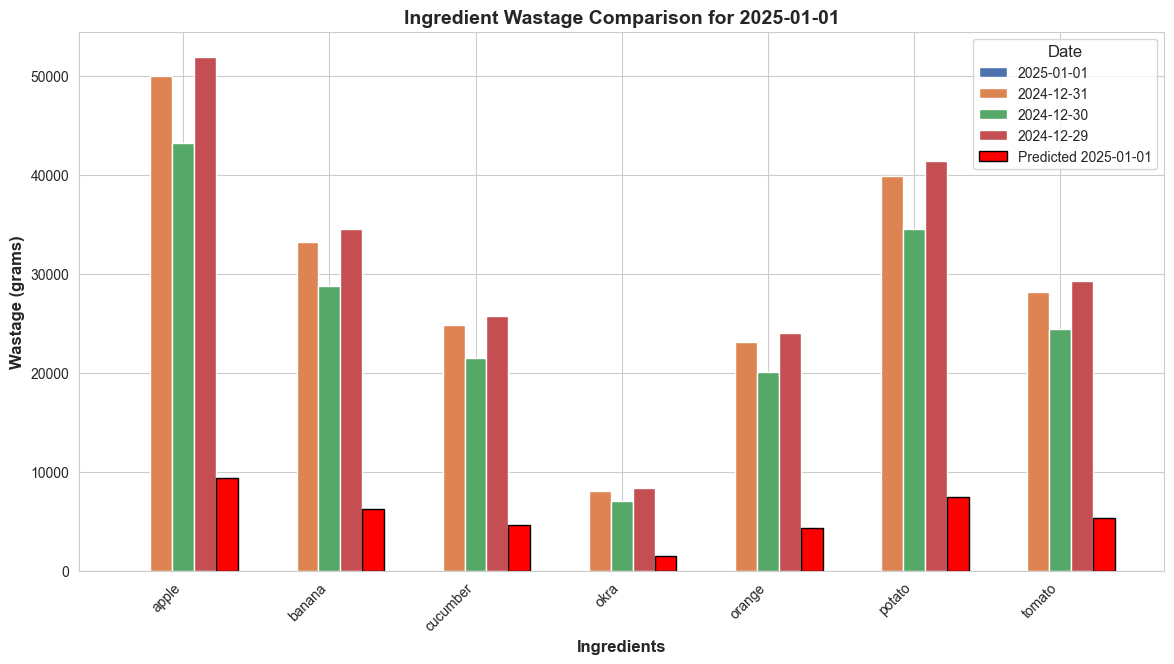

In [7]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv("final_dataset.csv")

# Convert date column to datetime format
df["date"] = pd.to_datetime(df["date"])

# Ensure dataset contains necessary columns
required_columns = ["date", "sale_units", "price"] + [f"stock_{ing}" for ing in ["apple", "banana", "cucumber", "okra", "orange", "potato", "tomato"]]
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    raise KeyError(f"Missing columns in dataset: {missing_columns}")

# Extract year, month, and day
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

# User input for target prediction date
custom_date = input("Enter the date (YYYY-MM-DD): ")
target_date = pd.to_datetime(custom_date)

# User input for number of past days to compare
x_days = int(input("Enter number of past days to compare: "))

# Generate past dates for comparison
comparison_dates = [target_date - pd.Timedelta(days=i) for i in range(x_days)]

# List of ingredients
ingredients = ["apple", "banana", "cucumber", "okra", "orange", "potato", "tomato"]

# Dictionary to store predicted wastage
predicted_wastage = {}

# Features for machine learning
features = ["sale_units", "price", "year"]

# Predict wastage using Linear Regression
for ing in ingredients:
    waste_col = f"waste_{ing}"
    stock_col = f"stock_{ing}"

    # Calculate wastage (stock - sales, clipped to avoid negatives)
    df[waste_col] = (df[stock_col] - df["sale_units"]).clip(lower=0)

    # Ensure no missing values in selected features
    if df[features + [waste_col]].isnull().any().any():
        df.dropna(subset=features + [waste_col], inplace=True)

    # Train ML model
    X = df[features]
    y = df[waste_col]

    if X.empty or y.empty:
        predicted_wastage[ing] = 0  # If no data available, predict 0 wastage
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict waste for the target date
    X_future = pd.DataFrame({"sale_units": [df["sale_units"].mean()], 
                             "price": [df["price"].mean()], 
                             "year": [target_date.year]})

    predicted_wastage[ing] = int(np.round(model.predict(X_future)[0]))  # Convert int64 to int

# Historical data collection for past `x_days`
historical_wastage = []
for date in comparison_dates:
    df_historical = df[df["date"] == date]

    wastage_data = {}
    for ing in ingredients:
        waste_col = f"waste_{ing}"
        wastage_data[ing] = int(df_historical[waste_col].sum()) if not df_historical.empty else 0

    historical_wastage.append({"date": date.strftime("%Y-%m-%d"), "wastage_data": wastage_data})

# Convert historical data to DataFrame
historical_df = []
for data in historical_wastage:
    date = data["date"]
    for ingredient, waste in data["wastage_data"].items():
        historical_df.append({"Date": date, "Ingredient": ingredient, "Wastage": waste})

historical_df = pd.DataFrame(historical_df)

# Convert predicted data to DataFrame
predicted_df = pd.DataFrame(list(predicted_wastage.items()), columns=["Ingredient", "Predicted_Wastage"])

# Get all unique ingredients
all_ingredients = sorted(set(predicted_df["Ingredient"]).union(set(historical_df["Ingredient"])))

# Reindex and fill missing values with 0
predicted_df = predicted_df.set_index("Ingredient").reindex(all_ingredients, fill_value=0).reset_index()
historical_df = historical_df.pivot(index="Ingredient", columns="Date", values="Wastage").reindex(all_ingredients, fill_value=0).reset_index()

# Add predicted wastage to historical data
historical_df["Predicted_Wastage"] = predicted_df["Predicted_Wastage"]

# Create JSON output
comparison_json = json.dumps({
    "target_date": custom_date,
    "historical_wastage": historical_wastage,
    "predicted_wastage": predicted_wastage
}, indent=4)

# Plot comparison
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

x = np.arange(len(all_ingredients))
width = 0.15

colors = sns.color_palette("deep", len(comparison_dates))
for i, (date, color) in enumerate(zip(comparison_dates, colors)):
    date_str = date.strftime("%Y-%m-%d")
    plt.bar(x + i * width, historical_df[date_str], width=width, label=f"{date_str}", color=color)

plt.bar(x + len(comparison_dates) * width, historical_df["Predicted_Wastage"], width=width, 
        color='red', label=f"Predicted {target_date.strftime('%Y-%m-%d')}", edgecolor='black')

plt.xlabel("Ingredients", fontsize=12, fontweight='bold')
plt.ylabel("Wastage (grams)", fontsize=12, fontweight='bold')
plt.title(f"Ingredient Wastage Comparison for {custom_date}", fontsize=14, fontweight='bold')
plt.xticks(x + (width * (len(comparison_dates) / 2)), all_ingredients, rotation=45, ha="right")
plt.legend(title="Date", fontsize=10, title_fontsize=12)
plt.show()
